In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.image as img
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score as r2, mean_absolute_error as mae, mean_squared_error as mse
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2, mean_absolute_error as mae, mean_squared_error as mse
from pylab import rcParams


from scipy.spatial.distance import cdist
from mpl_toolkits.mplot3d.axes3d import Axes3D

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


pd.set_option('display.max_columns', 100)

In [138]:
DATASET_TRAIN_PATH = 'train.csv'
df_train = pd.read_csv(DATASET_TRAIN_PATH)
PREPARED_TRAIN_DATASET_PATH = 'train_prepared.csv'
DATASET_TEST_PATH = 'test.csv'
df_test = pd.read_csv(DATASET_TEST_PATH)
PREPARED_TEST_DATASET_PATH = 'Petrova_predictions.csv'

# Функции

In [3]:
def apply_elbow_method(X):
    distortions = []
    K = range(2,15)
    for k in K:
        kmeanModel = KMeans(n_clusters=k, random_state=33).fit(X)
        distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

    plt.figure(figsize=(10, 8))
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

In [4]:
def display_clusters_distribution(unique_labels, labels_counts):
    plt.figure(figsize=(8,5))

    plt.bar(unique, counts)

    plt.xlabel('Clusters')
    plt.xticks(unique)
    plt.ylabel('Count')
    plt.title('Clusters distribution')
    plt.show()

In [5]:
def reduce_dims_to_2D_space_with_PCA(df):
    pca = PCA(n_components=2)
    components = pca.fit_transform(df)
    return pd.DataFrame(data = components, columns = ['component_1', 'component_2'])
    
def reduce_dims_to_3D_space_with_PCA(df):
    pca = PCA(n_components=3)
    components = pca.fit_transform(df)
    return pd.DataFrame(data = components, columns = ['component_1', 'component_2', 'component_3'])

def reduce_dims_to_2D_space_with_TSNE(df):
    tsne = TSNE(n_components=2, learning_rate=250, random_state=42)
    components = tsne.fit_transform(df)
    return pd.DataFrame(data = components, columns = ['component_1', 'component_2'])
    
def reduce_dims_to_3D_space_with_TSNE(df):
    tsne = TSNE(n_components=3, learning_rate=250, random_state=42)
    components = tsne.fit_transform(df)
    return pd.DataFrame(data = components, columns = ['component_1', 'component_2', 'component_3'])

In [6]:
def display_components_in_2D_space(components_df, labels=None):
    components_with_labels_df = pd.concat([components_df, labels], axis=1)

    if labels is not None:
        components_with_labels_df.plot(kind='scatter', x='component_1', y='component_2', 
                                         c=labels.name, cmap=plt.get_cmap('jet'),
                                         alpha=0.5, figsize=(15,10))
    else:
        components_with_labels_df.plot(kind='scatter', x='component_1', y='component_2', alpha=0.5, figsize=(15,10))

    plt.xlabel('component_1')
    plt.ylabel('component_2')
    plt.title('2D mapping of objects')    
    plt.show()

def display_components_in_3D_space(components_df, labels=None):
    components_with_labels_df = pd.concat([components_df, labels], axis=1)

    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(111, projection='3d')
    
    if labels is not None:
        ax.scatter(components_with_labels_df['component_1'], 
                   components_with_labels_df['component_2'], 
                   components_with_labels_df['component_3'], 
                   c=labels, cmap=plt.get_cmap('jet'), alpha=0.5)
    else:
        ax.scatter(components_with_labels_df['component_1'], 
                   components_with_labels_df['component_2'], 
                   components_with_labels_df['component_3'], 
                   alpha=0.5)

    ax.set_xlabel('component_1')
    ax.set_ylabel('component_2')
    ax.set_zlabel('component_3')
    plt.title('3D mapping of objects')
    plt.show()

In [7]:
def evaluate_preds(true_values, pred_values):
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "MAE:\t" + str(round(mae(true_values, pred_values), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3)))
    
    plt.figure(figsize=(10,10))
    
    sns.scatterplot(x=pred_values, y=true_values)
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    plt.show()

# Предобработка тренировочных и тестовых данных

In [8]:
df_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [9]:
df_test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


Исправление опечатки в названии переменной

In [10]:
df_train.rename(columns={'Helthcare_2': 'Healthcare_2'}, inplace=True)

df_test.rename(columns={'Helthcare_2': 'Healthcare_2'}, inplace=True)

Просмотр пустых значений и типов данных

In [11]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Healthcare_2   10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

Замена типа данных HouseFloor и Rooms (может быть только целым)

In [12]:
df_train['HouseFloor'] = df_train['HouseFloor'].astype('int64')

df_test['HouseFloor'] = df_test['HouseFloor'].astype('int64')

In [13]:
df_train['Rooms'] = df_train['Rooms'].astype('int64')

df_test['Rooms'] = df_test['Rooms'].astype('int64')

Обзор количественных переменных

In [14]:
df_train_num_features = df_train.select_dtypes(include=['float64', 'int64'])
df_train_num_features.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Healthcare_2,Shops_1,Price
0,14038,35,2,47.981561,29.442751,6.0,7,9,1969,0.089040,33,7976,5,NaN,0,11,184966.930730
1,15053,41,3,65.683640,40.049543,8.0,7,9,1978,0.000070,46,10309,1,240.0,1,16,300009.450063
2,4765,53,2,44.947953,29.197612,0.0,8,12,1968,0.049637,34,7759,0,229.0,1,3,220925.908524
3,5809,58,2,53.352981,52.731512,9.0,8,17,1977,0.437885,23,5735,3,1084.0,0,5,175616.227217
4,10783,99,1,39.649192,23.776169,7.0,11,12,1976,0.012339,35,5776,1,2078.0,2,4,150226.531644


In [15]:
df_train_num_features.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Healthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [16]:
df_test.loc[df_test['Rooms']>5]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Healthcare_2,Shops_1,Shops_2
2071,10793,23,6,110.750226,NaN,0.0,2,2,2015,0.014073,B,B,2,475,0,NaN,0,0,B
3217,4058,27,6,223.453689,104.113552,16.0,2,2,2017,0.041116,B,B,53,14892,4,NaN,1,4,B
3398,1435,111,17,52.866107,32.528342,8.0,15,17,1987,0.093443,B,B,23,4635,5,3300.0,2,4,B


In [17]:
df_test_num_features = df_test.select_dtypes(include=['float64', 'int64'])
df_test_num_features.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Healthcare_2,Shops_1
0,725,58,2,49.882643,33.432782,6.0,6,14,1972,0.310199,11,2748,1,NaN,0,0
1,15856,74,2,69.263183,NaN,1.0,6,1,1977,0.075779,6,1437,3,NaN,0,2
2,5480,190,1,13.597819,15.948246,12.0,2,5,1909,0.000000,30,7538,87,4702.0,5,5
3,15664,47,2,73.046609,51.940842,9.0,22,22,2007,0.101872,23,4583,3,NaN,3,3
4,14275,27,1,47.527111,43.387569,1.0,17,17,2017,0.072158,2,629,1,NaN,0,0


In [18]:
df_test_num_features.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Healthcare_2,Shops_1
count,5000.000000,5000.000000,5000.000000,5000.000000,3959.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,2623.000000,5000.00000,5000.000000
mean,8412.595400,51.279200,1.910000,56.449500,36.158810,5.976800,8.632000,12.601000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1146.657263,1.31940,4.242800
std,4832.674037,44.179466,0.838594,19.092787,17.825287,9.950018,5.483228,6.789213,18.573149,0.120070,17.532202,4026.614773,23.863762,1044.744231,1.47994,4.777365
min,1.000000,0.000000,0.000000,1.378543,0.333490,0.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,4221.750000,21.000000,1.000000,41.906231,23.092026,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,325.000000,0.00000,1.000000
50%,8320.500000,37.000000,2.000000,52.921340,32.925087,6.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,12598.250000,77.000000,2.000000,66.285129,45.174091,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.00000,6.000000
max,16795.000000,212.000000,17.000000,223.453689,303.071094,620.000000,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


Обрабатываем выбросы и ошибки

In [19]:
df_train.loc[df_train['Rooms'] == 19] = 1
df_train.loc[df_train['Rooms'] == 10] = 2
df_train.loc[df_train['Rooms'] == 6] = 2

In [20]:
df_train.loc[df_train['LifeSquare']>7000, 'LifeSquare'] = df_train['LifeSquare'].multiply(0.01)
df_train.loc[df_train['LifeSquare']>250, 'LifeSquare'] = df_train['LifeSquare'].multiply(0.1)
df_train.loc[df_train['Square']>400, 'Square'] = df_train['Square'].multiply(0.1)

df_test.loc[df_test['LifeSquare']>7000, 'LifeSquare'] = df_test['LifeSquare'].multiply(0.01)
df_test.loc[df_test['LifeSquare']>250, 'LifeSquare'] = df_test['LifeSquare'].multiply(0.1)
df_test.loc[df_test['Square']>400, 'Square'] = df_test['Square'].multiply(0.1)
df_test.loc[df_test['KitchenSquare']>200, 'KitchenSquare'] = df_test['KitchenSquare'].multiply(0.01)

Меняем местами общую и жилую площадь, если жилая площадь больше общей

In [21]:
df_train['LifeSquare2']=df_train['LifeSquare']

df_test['LifeSquare2']=df_test['LifeSquare']

In [22]:
df_train.loc[df_train['Square'] < df_train['LifeSquare'], 'LifeSquare'] = df_train['Square']
df_train.loc[df_train['Square'] == df_train['LifeSquare'], 'Square'] = df_train['LifeSquare2']
df_train = df_train.drop(['LifeSquare2'], axis = 1)

df_test.loc[df_test['Square'] < df_test['LifeSquare'], 'LifeSquare'] = df_test['Square']
df_test.loc[df_test['Square'] == df_test['LifeSquare'], 'Square'] = df_test['LifeSquare2']
df_test = df_test.drop(['LifeSquare2'], axis = 1)

Меняем местами этаж квартиры и общее количество этажей в здании, если этажей меньше, чем этаж, на котором находится квартира

In [23]:
df_train['HouseFloor2']=df_train['HouseFloor']

df_test['HouseFloor2']=df_test['HouseFloor']

In [24]:
df_train.loc[df_train['Floor'] > df_train['HouseFloor'], 'HouseFloor'] = df_train['Floor']
df_train.loc[df_train['Floor'] == df_train['HouseFloor'], 'Floor'] = df_train['HouseFloor2']
df_train = df_train.drop(['HouseFloor2'], axis = 1)

df_test.loc[df_test['Floor'] > df_test['HouseFloor'], 'HouseFloor'] = df_test['Floor']
df_test.loc[df_test['Floor'] == df_test['HouseFloor'], 'Floor'] = df_test['HouseFloor2']
df_test = df_test.drop(['HouseFloor2'], axis = 1)

In [25]:
df_train.loc[df_train['KitchenSquare']>1000, ['KitchenSquare']] = df_train['KitchenSquare']*0.01

df_test.loc[df_test['KitchenSquare']>200, 'KitchenSquare'] = df_test['KitchenSquare'].multiply(0.01)

In [26]:
df_train.loc[df_train['KitchenSquare']>100, 'KitchenSquare'] = df_train['KitchenSquare'].median()
df_test.loc[df_test['KitchenSquare']>100, 'KitchenSquare'] = df_train['KitchenSquare'].median()

Удаляем строки без данных (11111, 22222, 33333)

In [27]:
df_train = df_train.drop(1454, axis = 0)
df_train = df_train.drop(377, axis = 0)
df_train = df_train.drop(2170, axis = 0)
df_train = df_train.drop(8849, axis = 0)

In [28]:
df_train.loc[df_train['HouseYear']==20052011, 'HouseYear'] = 2008 

Обзор номинативных переменных

In [29]:
df_train_obj_features = df_train.select_dtypes(include='object')
df_train_obj_features.head()

,Ecology_2,Ecology_3,Shops_2
0,B,B,B
1,B,B,B
2,B,B,B
3,B,B,B
4,B,B,B


In [30]:
df_test_obj_features = df_test.select_dtypes(include='object')
df_test_obj_features.head()

,Ecology_2,Ecology_3,Shops_2
0,B,B,B
1,B,B,B
2,B,B,B
3,B,B,B
4,B,B,A


Обработка пропусков

In [31]:
len(df_train) - df_train.count()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4796
Healthcare_2        0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

In [32]:
len(df_test) - df_test.count()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       1041
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     2377
Healthcare_2        0
Shops_1             0
Shops_2             0
dtype: int64

In [33]:
(df_train['LifeSquare']/df_train['Square']).median()

0.6173188847525481

In [34]:
for i in range(0,7):
    
    df_train_new = df_train.iloc[:, :6].dropna()
    print(df_train_new.loc[df_train['Rooms'] == i, 'Square'].median())
    print(df_train_new.loc[df_train['Rooms'] == i, 'LifeSquare'].median())
    print(df_train_new.loc[df_train['Rooms'] == i, 'KitchenSquare'].median())

87.76261594988847
85.12547136559083
0.0
39.743680510662365
21.662834778006534
7.0
53.878399876425306
32.54130312500991
6.0
75.91079785988876
46.95462163225855
8.0
98.3854462844821
64.94654758809416
9.0
116.08486083443316
80.45891031600135
9.0
nan
nan
nan


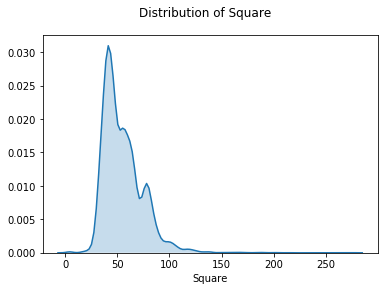

In [35]:
sns.kdeplot(df_train_new['Square'], shade=True, legend=False)
plt.xlabel('Square')

plt.suptitle('Distribution of Square')
plt.show()

Ограничим минимальную площадь 20 метрами

In [36]:
df_train.loc[df_train['Square']<20, ['Square']] = 20

df_test.loc[df_test['Square']<20, ['Square']] = 20

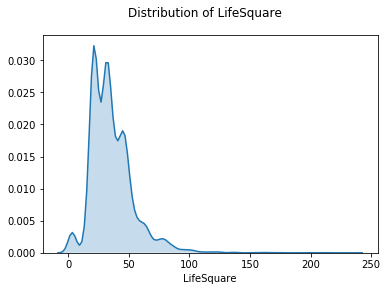

In [37]:
sns.kdeplot(df_train_new['LifeSquare'], shade=True, legend=False)
plt.xlabel('LifeSquare')

plt.suptitle('Distribution of LifeSquare')
plt.show()

In [38]:
df_train.loc[df_train['LifeSquare']<10, 'LifeSquare'] =df_train['Square']*0.65

df_test.loc[df_test['LifeSquare']<10, 'LifeSquare'] =df_test['Square']*0.65

In [39]:
df_test.loc[df_test['Rooms']>10, 'Rooms'] = 2
df_test.loc[df_test['Floor']==78,'Floor'] = 7

In [40]:
df_train.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Healthcare_2,Shops_1,Price
count,9996.000000,9996.000000,9996.000000,9996.000000,7883.000000,9996.000000,9996.000000,9996.000000,9996.000000,9996.000000,9996.000000,9996.000000,9996.000000,5200.000000,9996.000000,9996.000000,9996.000000
mean,8382.432073,50.404362,1.886755,56.290953,36.831728,5.845022,7.698679,13.435974,1985.162165,0.118876,24.680272,5350.740896,8.042017,1143.084038,1.319028,4.230192,214144.753182
std,4859.171330,43.588785,0.812964,19.141105,16.954910,4.815605,5.302065,6.093469,35.060271,0.119040,17.522709,4004.582192,23.836223,1021.594103,1.493277,4.805838,92874.147847
min,0.000000,0.000000,0.000000,20.000000,10.523868,0.000000,0.000000,1.000000,1910.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4167.750000,20.000000,1.000000,41.864637,23.417261,1.000000,4.000000,9.000000,1974.000000,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8393.500000,36.000000,2.000000,52.609490,33.147175,6.000000,7.000000,14.000000,1977.000000,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12591.250000,75.000000,2.000000,65.986649,45.256781,9.000000,11.000000,17.000000,2001.000000,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.000000,209.000000,5.000000,275.645284,233.949309,96.000000,42.000000,117.000000,4968.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


Разбираемся с 0 ккв

In [41]:
df_train.loc[(df_train['LifeSquare'].isna()) & (df_train['Rooms']==0), 'LifeSquare'] = df_train['Square']*0.65

df_test.loc[(df_test['LifeSquare'].isna()) & (df_test['Rooms']==0), 'LifeSquare'] = df_test['Square']*0.65

Разбираемся с 1 ккв

In [42]:
df_train.loc[((df_train['Square'] - df_train['KitchenSquare'] - df_train['LifeSquare'])<0) & (df_train['Rooms']==1), 'KitchenSquare'] = df_train.loc[df_train['Rooms']==1, 'KitchenSquare'].median()
df_train.loc[(df_train['LifeSquare'].isna()) & (df_train['Rooms']==1), 'LifeSquare'] = df_train['Square']-df_train['KitchenSquare']-10

df_test.loc[((df_test['Square'] - df_test['KitchenSquare'] - df_test['LifeSquare'])<0) & (df_test['Rooms']==1), 'KitchenSquare'] = df_train.loc[df_train['Rooms']==1, 'KitchenSquare'].median()
df_test.loc[(df_test['LifeSquare'].isna()) & (df_test['Rooms']==1), 'LifeSquare'] = df_test['Square']-df_test['KitchenSquare']-10

Разбираемся с 2 ккв


In [43]:
df_train.loc[((df_train['Square'] - df_train['KitchenSquare'] - df_train['LifeSquare'])<0) & (df_train['Rooms']==2), 'KitchenSquare'] = df_train.loc[df_train['Rooms']==2, 'KitchenSquare'].median()
df_train.loc[(df_train['LifeSquare'].isna()) & (df_train['Rooms']==2), 'LifeSquare'] = df_train['Square']-df_train['KitchenSquare']-14

df_test.loc[((df_test['Square'] - df_test['KitchenSquare'] - df_test['LifeSquare'])<0) & (df_test['Rooms']==2), 'KitchenSquare'] = df_train.loc[df_train['Rooms']==2, 'KitchenSquare'].median()
df_test.loc[(df_test['LifeSquare'].isna()) & (df_test['Rooms']==2), 'LifeSquare'] = df_test['Square']-df_test['KitchenSquare']-14

Разбираемся с 3 ккв

In [44]:
df_train.loc[((df_train['Square'] - df_train['KitchenSquare'] - df_train['LifeSquare'])<0) & (df_train['Rooms']==3), 'KitchenSquare'] = df_train.loc[df_train['Rooms']==3, 'KitchenSquare'].median()
df_train.loc[(df_train['LifeSquare'].isna()) & (df_train['Rooms']==3), 'LifeSquare'] = df_train['Square']-df_train['KitchenSquare']-20

df_test.loc[((df_test['Square'] - df_test['KitchenSquare'] - df_test['LifeSquare'])<0) & (df_test['Rooms']==3), 'KitchenSquare'] = df_train.loc[df_train['Rooms']==3, 'KitchenSquare'].median()
df_test.loc[(df_test['LifeSquare'].isna()) & (df_test['Rooms']==3), 'LifeSquare'] = df_test['Square']-df_test['KitchenSquare']-20

Разбираемся с 4 ккв

In [45]:
df_train.loc[((df_train['Square'] - df_train['KitchenSquare'] - df_train['LifeSquare'])<0) & (df_train['Rooms']==4), 'KitchenSquare'] = df_train.loc[df_train['Rooms']==4, 'KitchenSquare'].median()
df_train.loc[(df_train['LifeSquare'].isna()) & (df_train['Rooms']==4), 'LifeSquare'] = df_train['Square']-df_train['KitchenSquare']-24

df_test.loc[((df_test['Square'] - df_test['KitchenSquare'] - df_test['LifeSquare'])<0) & (df_test['Rooms']==4), 'KitchenSquare'] = df_train.loc[df_train['Rooms']==4, 'KitchenSquare'].median()
df_test.loc[(df_test['LifeSquare'].isna()) & (df_test['Rooms']==4), 'LifeSquare'] = df_test['Square']-df_test['KitchenSquare']-24

Разбираемся с 5 ккв

In [46]:
df_train.loc[((df_train['Square'] - df_train['KitchenSquare'] - df_train['LifeSquare'])<0) & (df_train['Rooms']==5), 'KitchenSquare'] = df_train.loc[df_train['Rooms']==5, 'KitchenSquare'].median()
df_train.loc[(df_train['LifeSquare'].isna()) & (df_train['Rooms']==5), 'LifeSquare'] = df_train['Square']-df_train['KitchenSquare']-27

df_test.loc[((df_test['Square'] - df_test['KitchenSquare'] - df_test['LifeSquare'])<0) & (df_test['Rooms']==5), 'KitchenSquare'] = df_train.loc[df_train['Rooms']==5, 'KitchenSquare'].median()
df_test.loc[(df_test['LifeSquare'].isna()) & (df_test['Rooms']==5), 'LifeSquare'] = df_test['Square']-df_test['KitchenSquare']-27

Разбираемся с 6 ккв

In [47]:
df_train.loc[((df_train['Square'] - df_train['KitchenSquare'] - df_train['LifeSquare'])<0) & (df_train['Rooms']==6), 'KitchenSquare'] = df_train.loc[df_train['Rooms']==6, 'KitchenSquare'].median()
df_train.loc[(df_train['LifeSquare'].isna()) & (df_train['Rooms']==6), 'LifeSquare'] = df_train['Square']-df_train['KitchenSquare']-28

df_test.loc[((df_test['Square'] - df_test['KitchenSquare'] - df_test['LifeSquare'])<0) & (df_test['Rooms']==6), 'KitchenSquare'] = df_train.loc[df_train['Rooms']==6, 'KitchenSquare'].median()
df_test.loc[(df_test['LifeSquare'].isna()) & (df_test['Rooms']==6), 'LifeSquare'] = df_test['Square']-df_test['KitchenSquare']-28

In [48]:
df_train.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Healthcare_2,Shops_1,Price
count,9996.000000,9996.000000,9996.000000,9996.000000,9996.000000,9996.000000,9996.000000,9996.000000,9996.000000,9996.000000,9996.000000,9996.000000,9996.000000,5200.000000,9996.000000,9996.000000,9996.000000
mean,8382.432073,50.404362,1.886755,56.290953,38.599593,5.712385,7.698679,13.435974,1985.162165,0.118876,24.680272,5350.740896,8.042017,1143.084038,1.319028,4.230192,214144.753182
std,4859.171330,43.588785,0.812964,19.141105,17.278868,3.863065,5.302065,6.093469,35.060271,0.119040,17.522709,4004.582192,23.836223,1021.594103,1.493277,4.805838,92874.147847
min,0.000000,0.000000,0.000000,20.000000,-11.140758,0.000000,0.000000,1.000000,1910.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4167.750000,20.000000,1.000000,41.864637,26.049644,1.000000,4.000000,9.000000,1974.000000,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8393.500000,36.000000,2.000000,52.609490,34.544365,6.000000,7.000000,14.000000,1977.000000,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12591.250000,75.000000,2.000000,65.986649,47.190071,8.000000,11.000000,17.000000,2001.000000,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.000000,209.000000,5.000000,275.645284,233.949309,62.000000,42.000000,117.000000,4968.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [49]:
df_test.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Healthcare_2,Shops_1
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,2623.000000,5000.00000,5000.000000
mean,8412.595400,51.279200,1.907000,56.567169,38.762813,5.724440,7.838000,13.395000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1146.657263,1.31940,4.242800
std,4832.674037,44.179466,0.810976,19.030314,16.781776,3.873845,5.454989,6.231945,18.573149,0.120070,17.532202,4026.614773,23.863762,1044.744231,1.47994,4.777365
min,1.000000,0.000000,0.000000,20.000000,-12.673956,0.000000,0.000000,1.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,4221.750000,21.000000,1.000000,41.989020,26.545012,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,325.000000,0.00000,1.000000
50%,8320.500000,37.000000,2.000000,52.930550,34.818210,6.000000,7.000000,14.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,12598.250000,77.000000,2.000000,66.392939,47.552920,8.000000,11.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.00000,6.000000
max,16795.000000,212.000000,6.000000,223.453689,168.729035,61.000000,46.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


In [50]:
df_train.loc[df_train['LifeSquare']<0, 'LifeSquare'] = df_train['Square'] * 0.65

df_test.loc[df_test['LifeSquare']<0, 'LifeSquare'] = df_test['Square'] * 0.65

In [51]:
df_train.loc[((df_train['Square'] - df_train['KitchenSquare'] - df_train['LifeSquare'])<0) & (df_train['LifeSquare']< df_train['KitchenSquare']) & (df_train['Rooms'] == 1), 'KitchenSquare'] = df_train.loc[df_train['Rooms']==1, 'KitchenSquare'].median()
df_train.loc[((df_train['Square'] - df_train['KitchenSquare'] - df_train['LifeSquare'])<0) & (df_train['LifeSquare']< df_train['KitchenSquare']) & (df_train['Rooms'] == 2), 'KitchenSquare'] = df_train.loc[df_train['Rooms']==2, 'KitchenSquare'].median()
df_train.loc[((df_train['Square'] - df_train['KitchenSquare'] - df_train['LifeSquare'])<0) & (df_train['LifeSquare']< df_train['KitchenSquare']) & (df_train['Rooms'] == 3), 'KitchenSquare'] = df_train.loc[df_train['Rooms']==3, 'KitchenSquare'].median()
df_train.loc[((df_train['Square'] - df_train['KitchenSquare'] - df_train['LifeSquare'])<0) & (df_train['LifeSquare']< df_train['KitchenSquare']) & (df_train['Rooms'] == 4), 'KitchenSquare'] = df_train.loc[df_train['Rooms']==4, 'KitchenSquare'].median()
df_train.loc[((df_train['Square'] - df_train['KitchenSquare'] - df_train['LifeSquare'])<0) & (df_train['LifeSquare']< df_train['KitchenSquare']) & (df_train['Rooms'] == 5), 'KitchenSquare'] = df_train.loc[df_train['Rooms']==5, 'KitchenSquare'].median()
df_train.loc[((df_train['Square'] - df_train['KitchenSquare'] - df_train['LifeSquare'])<0) & (df_train['LifeSquare']< df_train['KitchenSquare']) & (df_train['Rooms'] == 6), 'KitchenSquare'] = df_train.loc[df_train['Rooms']==6, 'KitchenSquare'].median()

df_test.loc[((df_test['Square'] - df_test['KitchenSquare'] - df_test['LifeSquare'])<0) & (df_test['LifeSquare']< df_test['KitchenSquare']) & (df_test['Rooms'] == 1), 'KitchenSquare'] = df_train.loc[df_train['Rooms']==1, 'KitchenSquare'].median()
df_test.loc[((df_test['Square'] - df_test['KitchenSquare'] - df_test['LifeSquare'])<0) & (df_test['LifeSquare']< df_test['KitchenSquare']) & (df_test['Rooms'] == 2), 'KitchenSquare'] = df_train.loc[df_train['Rooms']==2, 'KitchenSquare'].median()
df_test.loc[((df_test['Square'] - df_test['KitchenSquare'] - df_test['LifeSquare'])<0) & (df_test['LifeSquare']< df_test['KitchenSquare']) & (df_test['Rooms'] == 3), 'KitchenSquare'] = df_train.loc[df_train['Rooms']==3, 'KitchenSquare'].median()
df_test.loc[((df_test['Square'] - df_test['KitchenSquare'] - df_test['LifeSquare'])<0) & (df_test['LifeSquare']< df_test['KitchenSquare']) & (df_test['Rooms'] == 4), 'KitchenSquare'] = df_train.loc[df_train['Rooms']==4, 'KitchenSquare'].median()
df_test.loc[((df_test['Square'] - df_test['KitchenSquare'] - df_test['LifeSquare'])<0) & (df_test['LifeSquare']< df_test['KitchenSquare']) & (df_test['Rooms'] == 5), 'KitchenSquare'] = df_train.loc[df_train['Rooms']==5, 'KitchenSquare'].median()
df_test.loc[((df_test['Square'] - df_test['KitchenSquare'] - df_test['LifeSquare'])<0) & (df_test['LifeSquare']< df_test['KitchenSquare']) & (df_test['Rooms'] == 6), 'KitchenSquare'] = df_train.loc[df_train['Rooms']==6, 'KitchenSquare'].median()

Повторяем процедуру

In [52]:
df_train.loc[((df_train['Square'] - df_train['KitchenSquare'] - df_train['LifeSquare'])<0) & (df_train['Rooms']==1), 'LifeSquare'] = df_train['Square']-df_train['KitchenSquare']-10
df_train.loc[((df_train['Square'] - df_train['KitchenSquare'] - df_train['LifeSquare'])<0) & (df_train['Rooms']==2), 'LifeSquare'] = df_train['Square']-df_train['KitchenSquare']-14
df_train.loc[((df_train['Square'] - df_train['KitchenSquare'] - df_train['LifeSquare'])<0) & (df_train['Rooms']==3), 'LifeSquare'] = df_train['Square']-df_train['KitchenSquare']-20
df_train.loc[((df_train['Square'] - df_train['KitchenSquare'] - df_train['LifeSquare'])<0) & (df_train['Rooms']==4), 'LifeSquare'] = df_train['Square']-df_train['KitchenSquare']-24
df_train.loc[((df_train['Square'] - df_train['KitchenSquare'] - df_train['LifeSquare'])<0) & (df_train['Rooms']==5), 'LifeSquare'] = df_train['Square']-df_train['KitchenSquare']-27

df_test.loc[((df_test['Square'] - df_test['KitchenSquare'] - df_test['LifeSquare'])<0) & (df_test['Rooms']==1), 'LifeSquare'] = df_test['Square']-df_test['KitchenSquare']-10
df_test.loc[((df_test['Square'] - df_test['KitchenSquare'] - df_test['LifeSquare'])<0) & (df_test['Rooms']==2), 'LifeSquare'] = df_test['Square']-df_test['KitchenSquare']-14
df_test.loc[((df_test['Square'] - df_test['KitchenSquare'] - df_test['LifeSquare'])<0) & (df_test['Rooms']==3), 'LifeSquare'] = df_test['Square']-df_test['KitchenSquare']-20
df_test.loc[((df_test['Square'] - df_test['KitchenSquare'] - df_test['LifeSquare'])<0) & (df_test['Rooms']==4), 'LifeSquare'] = df_test['Square']-df_test['KitchenSquare']-24
df_test.loc[((df_test['Square'] - df_test['KitchenSquare'] - df_test['LifeSquare'])<0) & (df_test['Rooms']==5), 'LifeSquare'] = df_test['Square']-df_test['KitchenSquare']-27

In [53]:
df_train.loc[df_train['HouseYear']>2050, 'HouseYear'] = df_train['HouseYear'].median()

df_train.loc[df_train['KitchenSquare']> 1900, 'KitchenSquare'] = df_train['KitchenSquare'].median()

In [54]:
df_train.loc[df_train['LifeSquare']<10, 'LifeSquare'] = df_train['Square'] * 0.65
df_test.loc[df_test['LifeSquare']<10, 'LifeSquare'] = df_test['Square'] * 0.65

In [55]:
df_test.loc[df_test['Rooms'] >5]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Healthcare_2,Shops_1,Shops_2
2071,10793,23,6,110.750226,82.750226,0.0,2,2,2015,0.014073,B,B,2,475,0,NaN,0,0,B
3217,4058,27,6,223.453689,104.113552,16.0,2,2,2017,0.041116,B,B,53,14892,4,NaN,1,4,B


Преобразуем категориальные признаки "Ecology_2", "Ecology_3", "Shops_2" в несколько бинарных

In [56]:
df_train = pd.concat([df_train, pd.get_dummies(df_train['Ecology_2'])], axis=1)
df_train.rename(columns={'A': 'Ecology_2_A', 'B': 'Ecology_2_B'}, inplace=True)

df_train = pd.concat([df_train, pd.get_dummies(df_train['Ecology_3'])], axis=1)
df_train.rename(columns={'A': 'Ecology_3_A', 'B': 'Ecology_3_B'}, inplace=True)

df_train = pd.concat([df_train, pd.get_dummies(df_train['Shops_2'])], axis=1)
df_train.rename(columns={'A': 'Shops_2_A', 'B': 'Shops_2_B'}, inplace=True)



df_test = pd.concat([df_test, pd.get_dummies(df_test['Ecology_2'])], axis=1)
df_test.rename(columns={'A': 'Ecology_2_A', 'B': 'Ecology_2_B'}, inplace=True)

df_test = pd.concat([df_test, pd.get_dummies(df_test['Ecology_3'])], axis=1)
df_test.rename(columns={'A': 'Ecology_3_A', 'B': 'Ecology_3_B'}, inplace=True)

df_test = pd.concat([df_test, pd.get_dummies(df_test['Shops_2'])], axis=1)
df_test.rename(columns={'A': 'Shops_2_A', 'B': 'Shops_2_B'}, inplace=True)


Преобразуем признаки "Rooms", "Healthcare_2" в несколько бинарных

In [57]:
df_train = pd.concat([df_train, pd.get_dummies(df_train['Rooms'])], axis=1)
df_train.rename(columns={0: 'Rooms_0', 1: 'Rooms_1', 2: 'Rooms_2', 3: 'Rooms_3', 4: 'Rooms_4', 5: 'Rooms_5'}, inplace=True)

df_test = pd.concat([df_test, pd.get_dummies(df_test['Rooms'])], axis=1)
df_test.rename(columns={0: 'Rooms_0', 1: 'Rooms_1', 2: 'Rooms_2', 3: 'Rooms_3', 4: 'Rooms_4', 5: 'Rooms_5', 6: 'Rooms_6'}, inplace=True)

In [58]:
df_train = pd.concat([df_train, pd.get_dummies(df_train['Healthcare_2'])], axis=1)
df_train.rename(columns={0: 'Healthcare_2_0', 1: 'Healthcare_2_1', 2: 'Halthcare_2_2', 3: 'Healthcare_2_3', 4: 'Healthcare_2_4', 5: 'Healthcare_2_5', 6: 'Healthcare_2_6'}, inplace=True)

df_test = pd.concat([df_test, pd.get_dummies(df_test['Healthcare_2'])], axis=1)
df_test.rename(columns={0: 'Healthcare_2_0', 1: 'Healthcare_2_1', 2: 'Halthcare_2_2', 3: 'Healthcare_2_3', 4: 'Healthcare_2_4', 5: 'Healthcare_2_5', 6: 'Healthcare_2_6'}, inplace=True)

# Работа с Healthcare_1

In [59]:
df_train.corr()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Healthcare_2,Shops_1,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B,Rooms_0,Rooms_1,Rooms_2,Rooms_3,Rooms_4,Rooms_5,Healthcare_2_0,Healthcare_2_1,Halthcare_2_2,Healthcare_2_3,Healthcare_2_4,Healthcare_2_5,Healthcare_2_6
Id,1.000000,0.012985,-0.007499,-0.005628,-0.008424,0.010172,-0.003731,-0.004276,0.003582,0.018127,-0.000902,-0.002020,-0.009298,-0.003639,0.001438,-0.008691,0.009984,-0.003080,0.003080,0.005443,-0.005443,-0.003585,0.003585,-0.016116,0.003845,0.002766,-0.003453,-0.001806,-0.025733,-0.003981,0.008965,0.005808,-0.016843,0.003968,0.006293,0.008159
DistrictId,0.012985,1.000000,0.076411,-0.030429,-0.100456,0.248306,-0.078802,-0.200790,-0.200724,0.065322,0.246237,0.167300,0.136091,0.304177,0.306108,0.174095,0.264950,0.093414,-0.093414,0.027893,-0.027893,0.020997,-0.020997,-0.011869,-0.057516,0.006542,0.040870,0.058040,0.019853,-0.317686,0.025717,0.092062,0.236010,0.130714,0.028120,0.014995
Rooms,-0.007499,0.076411,1.000000,0.754180,0.641807,0.144136,-0.004180,-0.035738,-0.044386,-0.031195,0.077363,0.072254,0.014640,0.045296,0.064048,0.054227,0.570812,0.002492,-0.002492,0.006878,-0.006878,0.001533,-0.001533,-0.065686,-0.837120,0.110956,0.734888,0.320860,0.162659,-0.087948,0.057551,0.016550,0.006932,0.038708,0.021578,0.011447
Square,-0.005628,-0.030429,0.754180,1.000000,0.893111,0.105857,0.071314,0.136165,0.192737,-0.070906,-0.081574,-0.051426,0.022140,-0.039763,-0.034601,0.009433,0.577638,-0.032723,0.032723,-0.024645,0.024645,0.056488,-0.056488,0.040710,-0.597221,0.012067,0.581105,0.271894,0.147177,0.067906,-0.036890,-0.012624,-0.052219,-0.005652,0.016345,0.030453
LifeSquare,-0.008424,-0.100456,0.641807,0.893111,1.000000,-0.233580,0.022352,0.092919,0.113281,-0.070800,-0.199965,-0.163614,0.038155,-0.072363,-0.102252,-0.030701,0.424364,-0.032531,0.032531,-0.050016,0.050016,0.071286,-0.071286,0.059486,-0.523934,0.033447,0.488206,0.216506,0.125805,0.157923,-0.089428,-0.037526,-0.061475,-0.028477,-0.021456,0.028287
KitchenSquare,0.010172,0.248306,0.144136,0.105857,-0.233580,1.000000,0.116385,0.066487,0.169835,0.024029,0.388424,0.351411,-0.061272,0.118642,0.226818,0.119435,0.323965,0.012669,-0.012669,0.082843,-0.082843,-0.048716,0.048716,-0.033931,-0.081388,-0.043527,0.117322,0.088276,0.044010,-0.301095,0.172536,0.080372,0.044177,0.072056,0.106719,0.025914
Floor,-0.003731,-0.078802,-0.004180,0.071314,0.022352,0.116385,1.000000,0.585684,0.267612,0.008371,0.008664,0.024815,0.001609,-0.109751,-0.026222,0.036883,0.109818,-0.038260,0.038260,-0.006015,0.006015,-0.048851,0.048851,-0.028418,0.019628,-0.035849,0.029503,-0.022008,-0.019394,0.021455,0.012961,-0.030869,-0.002990,-0.040069,0.026273,-0.033569
HouseFloor,-0.004276,-0.200790,-0.035738,0.136165,0.092919,0.066487,0.585684,1.000000,0.448463,-0.025695,-0.069928,-0.028731,-0.012312,-0.178223,-0.110585,0.017379,0.113190,-0.075417,0.075417,-0.027191,0.027191,-0.002427,0.002427,-0.020604,0.061928,-0.063088,0.006171,-0.004780,-0.013495,0.107770,0.000209,-0.044311,-0.070422,-0.061988,0.008449,-0.041643
HouseYear,0.003582,-0.200724,-0.044386,0.192737,0.113281,0.169835,0.267612,0.448463,1.000000,-0.066338,-0.047800,0.013659,-0.049317,-0.205251,-0.116322,-0.002133,0.036823,-0.076813,0.076813,-0.047152,0.047152,0.058888,-0.058888,0.009627,0.080116,-0.087289,0.008742,0.002260,-0.008143,0.102732,0.026505,-0.053613,-0.076018,-0.097375,0.004170,-0.006993
Ecology_1,0.018127,0.065322,-0.031195,-0.070906,-0.070800,0.024029,0.008371,-0.025695,-0.066338,1.000000,0.026594,0.009324,-0.124129,-0.043500,0.030928,-0.076731,-0.058479,0.110719,-0.110719,0.223190,-0.223190,-0.079862,0.079862,0.007887,0.022813,0.003963,-0.030466,-0.001936,-0.005745,-0.014898,-0.075391,0.068521,0.045376,0.037052,0.014760,-0.094777


In [60]:
feature_names = [
    'DistrictId',
    'HouseYear',
    'Social_3',
    'Healthcare_2',
    'Ecology_2_A'
]
target_name = ['Healthcare_1']

In [61]:
df_train_healthcare = df_train[feature_names + target_name].dropna()

## Заполняем на трейне

In [62]:
X = df_train_healthcare[feature_names]
y = df_train_healthcare[target_name]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, shuffle = True, random_state=42)

In [63]:
max_depth_arr = np.arange(2,20)

In [64]:
r2_score_train = []
r2_score_valid = []
for val in max_depth_arr:
    dt_model = DecisionTreeRegressor(max_depth=val, random_state=100)
    dt_model.fit(X_train, y_train.values.ravel())
    y_pred_train = dt_model.predict(X_train)
    y_pred_valid = dt_model.predict(X_valid)
    r2_train = r2(y_train, y_pred_train)
    r2_valid = r2(y_valid, y_pred_valid)
    r2_score_train.append(r2_train)
    r2_score_valid.append(r2_valid)

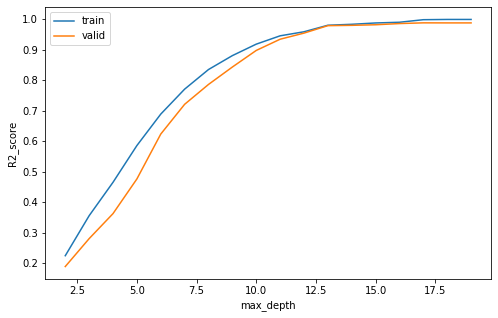

In [65]:
rcParams['figure.figsize'] = 8, 5
plt.plot(max_depth_arr, r2_score_train)
plt.plot(max_depth_arr, r2_score_valid)
plt.xlabel('max_depth')
plt.ylabel('R2_score')
plt.legend(['train', 'valid'])

R2:	0.998
MAE:	2.846
MSE:	1863.32


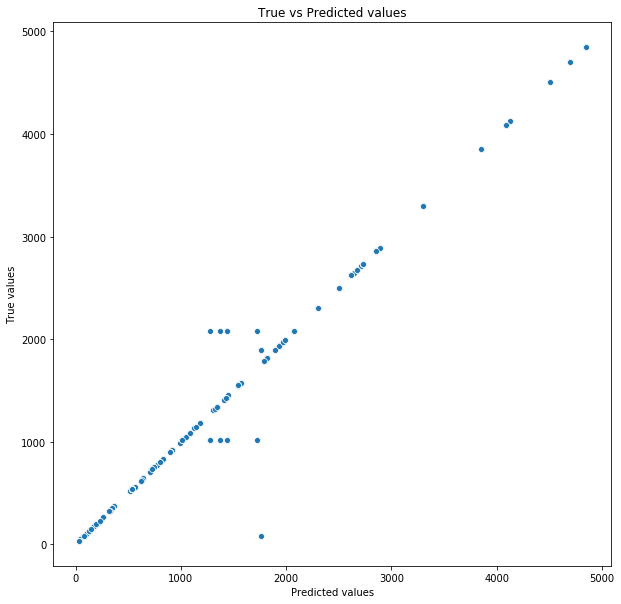

In [66]:
dt_model = DecisionTreeRegressor(max_depth=17)
dt_model.fit(X_train, y_train)
y_train_preds = dt_model.predict(X_train)
evaluate_preds(y_train.values.flatten(), y_train_preds.flatten())

R2:	0.986
MAE:	14.368
MSE:	14427.257


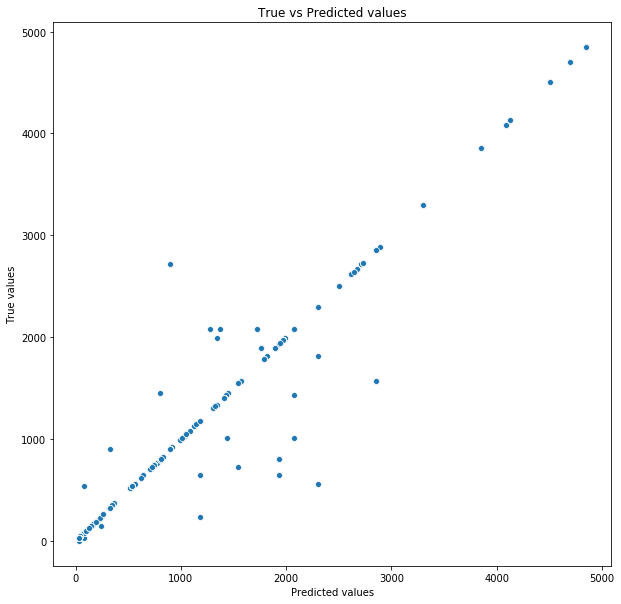

In [67]:
y_valid_preds = dt_model.predict(X_valid)
evaluate_preds(y_valid.values.flatten(), y_valid_preds.flatten())

In [68]:
X_train = df_train_healthcare[feature_names]
y_train = df_train_healthcare[target_name]
df_test_healthcare = df_train[feature_names + target_name]
df_test_healthcare = df_test_healthcare.loc[df_test_healthcare['Healthcare_1'].isna()]
X_test = df_test_healthcare[feature_names]
y_test = df_test_healthcare[target_name]

In [69]:
dt_model = DecisionTreeRegressor(max_depth=17)
dt_model.fit(X_train, y_train)
y_test_preds = dt_model.predict(X_test)

In [70]:
df_test_healthcare['Healthcare_1'] = y_test_preds
print(df_train_healthcare.head(10),df_test_healthcare.head(10))

    DistrictId  HouseYear  Social_3  Healthcare_2  Ecology_2_A  Healthcare_1
1           41     1978.0         1             1            0         240.0
2           53     1968.0         0             1            0         229.0
3           58     1977.0         3             0            0        1084.0
4           99     1976.0         1             2            0        2078.0
5           59     2011.0         4             0            0         990.0
10          28     1973.0         1             1            0        1183.0
13          57     1980.0         3             3            0        1406.0
15          85     1979.0         1             1            0        2300.0
18          57     1983.0         3             3            0        1406.0
20           0     2002.0        16             5            0        2857.0     DistrictId  HouseYear  Social_3  Healthcare_2  Ecology_2_A  Healthcare_1
0           35     1969.0         5             0            0         320.0

In [71]:
df_healthcare =pd.concat([df_train_healthcare,df_test_healthcare])
df_healthcare = df_healthcare.sort_index()
df_healthcare.head(10)

,DistrictId,HouseYear,Social_3,Healthcare_2,Ecology_2_A,Healthcare_1
0,35,1969.0,5,0,0,320.0
1,41,1978.0,1,1,0,240.0
2,53,1968.0,0,1,0,229.0
3,58,1977.0,3,0,0,1084.0
4,99,1976.0,1,2,0,2078.0
5,59,2011.0,4,0,0,990.0
6,154,1960.0,14,1,0,1020.0
7,74,1977.0,3,0,0,990.0
8,1,1977.0,0,0,0,240.0
9,23,2014.0,3,0,0,1406.0


In [72]:
df_train['Healthcare_1'] = df_healthcare['Healthcare_1']

In [73]:
df_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Healthcare_2,Shops_1,Shops_2,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B,Rooms_0,Rooms_1,Rooms_2,Rooms_3,Rooms_4,Rooms_5,Healthcare_2_0,Healthcare_2_1,Halthcare_2_2,Healthcare_2_3,Healthcare_2_4,Healthcare_2_5,Healthcare_2_6
0,14038,35,2,47.981561,29.442751,6.0,7,9,1969.0,0.089040,B,B,33,7976,5,320.0,0,11,B,184966.930730,0,1,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0
1,15053,41,3,65.683640,40.049543,8.0,7,9,1978.0,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063,0,1,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0
2,4765,53,2,44.947953,29.197612,0.0,8,12,1968.0,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524,0,1,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0
3,5809,58,2,53.352981,33.352981,6.0,8,17,1977.0,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217,0,1,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0
4,10783,99,1,39.649192,23.776169,7.0,11,12,1976.0,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644,0,1,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0


In [74]:
len(df_train) - df_train.count()

Id                0
DistrictId        0
Rooms             0
Square            0
LifeSquare        0
KitchenSquare     0
Floor             0
HouseFloor        0
HouseYear         0
Ecology_1         0
Ecology_2         0
Ecology_3         0
Social_1          0
Social_2          0
Social_3          0
Healthcare_1      0
Healthcare_2      0
Shops_1           0
Shops_2           0
Price             0
Ecology_2_A       0
Ecology_2_B       0
Ecology_3_A       0
Ecology_3_B       0
Shops_2_A         0
Shops_2_B         0
Rooms_0           0
Rooms_1           0
Rooms_2           0
Rooms_3           0
Rooms_4           0
Rooms_5           0
Healthcare_2_0    0
Healthcare_2_1    0
Halthcare_2_2     0
Healthcare_2_3    0
Healthcare_2_4    0
Healthcare_2_5    0
Healthcare_2_6    0
dtype: int64

## Заполняем на тесте

In [75]:
X_train = df_train[feature_names]
y_train = df_train[target_name]

X_test= df_test[feature_names]
y_test= df_test[target_name]

In [76]:
y_test_preds = dt_model.predict(X_test)
y_test_preds

In [78]:
df_test['Healthcare_1'] = y_test_preds

In [79]:
df_test.head(20)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Healthcare_2,Shops_1,Shops_2,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B,Rooms_0,Rooms_1,Rooms_2,Rooms_3,Rooms_4,Rooms_5,Rooms_6,Healthcare_2_0,Healthcare_2_1,Halthcare_2_2,Healthcare_2_3,Healthcare_2_4,Healthcare_2_5,Healthcare_2_6
0,725,58,2,49.882643,33.432782,6.0,6,14,1972,0.310199,B,B,11,2748,1,145.0,0,0,B,0,1,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0
1,15856,74,2,69.263183,54.263183,1.0,1,6,1977,0.075779,B,B,6,1437,3,990.0,0,2,B,0,1,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0
2,5480,190,1,20.000000,13.597819,6.0,2,5,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0
3,15664,47,2,73.046609,51.940842,9.0,22,22,2007,0.101872,B,B,23,4583,3,1308.0,3,3,B,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0
4,14275,27,1,47.527111,43.387569,1.0,17,17,2017,0.072158,B,B,2,629,1,1183.0,0,0,A,0,1,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
5,7633,53,1,40.675627,29.675627,1.0,21,21,1977,0.049637,B,B,34,7759,0,229.0,1,3,B,0,1,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0
6,13329,23,2,68.099538,64.843025,1.0,2,17,1977,0.075779,B,B,6,1437,3,1406.0,0,2,B,0,1,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0
7,5502,32,2,48.193897,32.857644,6.0,5,14,1972,0.135650,B,B,46,7960,6,350.0,3,11,B,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0
8,4220,96,3,72.277106,45.968758,9.0,17,17,1997,0.041116,B,B,53,14892,4,46.0,1,4,B,0,1,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0
9,11538,6,3,80.219400,47.660260,9.0,13,17,2014,0.243205,B,B,5,1564,0,540.0,0,0,B,0,1,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0


# Работа с DistrictId

In [80]:
df_train_district = df_train
df_test_district = df_test

In [81]:
df_train_district.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Healthcare_2,Shops_1,Shops_2,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B,Rooms_0,Rooms_1,Rooms_2,Rooms_3,Rooms_4,Rooms_5,Healthcare_2_0,Healthcare_2_1,Halthcare_2_2,Healthcare_2_3,Healthcare_2_4,Healthcare_2_5,Healthcare_2_6
0,14038,35,2,47.981561,29.442751,6.0,7,9,1969.0,0.089040,B,B,33,7976,5,320.0,0,11,B,184966.930730,0,1,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0
1,15053,41,3,65.683640,40.049543,8.0,7,9,1978.0,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063,0,1,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0
2,4765,53,2,44.947953,29.197612,0.0,8,12,1968.0,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524,0,1,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0
3,5809,58,2,53.352981,33.352981,6.0,8,17,1977.0,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217,0,1,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0
4,10783,99,1,39.649192,23.776169,7.0,11,12,1976.0,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644,0,1,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0


In [82]:
df_test_district.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Healthcare_2,Shops_1,Shops_2,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B,Rooms_0,Rooms_1,Rooms_2,Rooms_3,Rooms_4,Rooms_5,Rooms_6,Healthcare_2_0,Healthcare_2_1,Halthcare_2_2,Healthcare_2_3,Healthcare_2_4,Healthcare_2_5,Healthcare_2_6
0,725,58,2,49.882643,33.432782,6.0,6,14,1972,0.310199,B,B,11,2748,1,145.0,0,0,B,0,1,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0
1,15856,74,2,69.263183,54.263183,1.0,1,6,1977,0.075779,B,B,6,1437,3,990.0,0,2,B,0,1,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0
2,5480,190,1,20.000000,13.597819,6.0,2,5,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0
3,15664,47,2,73.046609,51.940842,9.0,22,22,2007,0.101872,B,B,23,4583,3,1308.0,3,3,B,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0
4,14275,27,1,47.527111,43.387569,1.0,17,17,2017,0.072158,B,B,2,629,1,1183.0,0,0,A,0,1,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0


In [83]:
df_train_district = pd.concat([df_train, pd.get_dummies(df_train['DistrictId'])], axis=1)
df_test_district = pd.concat([df_test, pd.get_dummies(df_test['DistrictId'])], axis=1)

In [84]:
df_train_district.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Healthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Ecology_2_A',
 'Ecology_2_B',
 'Ecology_3_A',
 'Ecology_3_B',
 'Shops_2_A',
 'Shops_2_B',
 'Rooms_0',
 'Rooms_1',
 'Rooms_2',
 'Rooms_3',
 'Rooms_4',
 'Rooms_5',
 'Healthcare_2_0',
 'Healthcare_2_1',
 'Halthcare_2_2',
 'Healthcare_2_3',
 'Healthcare_2_4',
 'Healthcare_2_5',
 'Healthcare_2_6',
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,


In [85]:
df_train_district.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Healthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Ecology_2_A',
 'Ecology_2_B',
 'Ecology_3_A',
 'Ecology_3_B',
 'Shops_2_A',
 'Shops_2_B',
 'Rooms_0',
 'Rooms_1',
 'Rooms_2',
 'Rooms_3',
 'Rooms_4',
 'Rooms_5',
 'Healthcare_2_0',
 'Healthcare_2_1',
 'Halthcare_2_2',
 'Healthcare_2_3',
 'Healthcare_2_4',
 'Healthcare_2_5',
 'Healthcare_2_6',
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,


In [86]:
feature_names = [
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Shops_1',
 'Ecology_2_A',
 'Ecology_2_B',
 'Ecology_3_A',
 'Ecology_3_B',
 'Shops_2_A',
 'Shops_2_B',
 'Rooms_0',
 'Rooms_1',
 'Rooms_2',
 'Rooms_3',
 'Rooms_4',
 'Rooms_5',
 'Healthcare_2_0',
 'Healthcare_2_1',
 'Halthcare_2_2',
 'Healthcare_2_3',
 'Healthcare_2_4',
 'Healthcare_2_5',
 'Healthcare_2_6',
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 159,
 160,
 161,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 186,
 187,
 188,
 189,
 190,
 191,
 192,
 193,
 194,
 196,
 200,
 205,
 208,
 209]
target_name = ['Price']

In [87]:
df_train_district = df_train_district[feature_names]
df_test_district = df_test_district[feature_names]

In [88]:
pca = PCA(n_components=3)
components_3d_PCA_train = pca.fit_transform(df_train_district)
components_3d_PCA_train = pd.DataFrame(data = components_3d_PCA_train, columns = ['component_1', 'component_2', 'component_3'])

In [89]:
components_3d_PCA_test = pca.transform(df_test_district)
components_3d_PCA_test = pd.DataFrame(data = components_3d_PCA_test, columns = ['component_1', 'component_2', 'component_3'])

In [90]:
components_3d_PCA_test

,component_1,component_2,component_3
0,-2600.880167,-854.798947,-13.408146
1,-3913.783705,-12.752648,13.475445
2,2179.059348,3713.373206,-28.964130
3,-768.451632,312.105980,23.830859
4,-4722.207378,178.284410,0.629512
...,...,...,...
4995,640.978591,137.386478,9.558951
4996,-5085.089276,-765.490824,-17.925530
4997,13734.116513,-787.580772,26.932383
4998,-4724.720357,1295.406679,28.765197


In [91]:
scaler = StandardScaler()
df_train_district_scaled = scaler.fit_transform(df_train_district)
df_train_district_scaled = pd.DataFrame(df_train_district_scaled, columns = df_train_district.columns)

In [92]:
df_test_district_scaled = scaler.transform(df_test_district)
df_test_district_scaled = pd.DataFrame(df_test_district_scaled, columns = df_test_district.columns)

In [93]:
#apply_elbow_method(df_train_district_scaled)

In [94]:
kmeans_5 = KMeans(n_clusters=5, random_state=33)

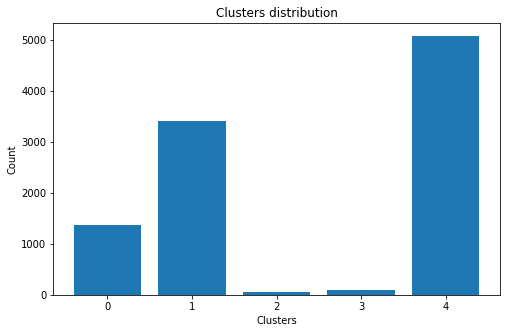

In [95]:
labels_clast_5_train = kmeans_5.fit_predict(df_train_district_scaled)
labels_clast_5_train = pd.Series(labels_clast_5_train, name='clusters_5')

labels_clast_5_train
unique, counts = np.unique(labels_clast_5_train, return_counts=True)
display_clusters_distribution(unique, counts)

In [96]:
df_test_district_scaled

,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Shops_1,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B,Rooms_0,Rooms_1,Rooms_2,Rooms_3,Rooms_4,Rooms_5,Healthcare_2_0,Healthcare_2_1,Halthcare_2_2,Healthcare_2_3,Healthcare_2_4,Healthcare_2_5,Healthcare_2_6,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,...,147,148,149,150,151,152,153,154,155,156,157,159,160,161,163,164,165,166,167,168,169,170,171,172,173,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,196,200,205,208,209
0,-0.334810,-0.251982,0.076726,-0.320397,0.092567,-0.698693,1.607304,-0.780756,-0.649973,-0.295448,-0.901535,-0.880263,-0.09899,0.09899,-0.168194,0.168194,-0.299929,0.299929,-0.028301,-0.767422,1.255503,-0.536636,-0.123429,-0.042473,1.171604,-0.528589,-0.361797,-0.447697,-0.172239,-0.200686,-0.100015,-0.069463,-0.263937,-0.088682,-0.090946,-0.033191,-0.058421,-0.232109,-0.09638,-0.120043,-0.173772,-0.075059,-0.114341,-0.080273,-0.09899,-0.041274,-0.06012,-0.024507,-0.077055,-0.071611,...,-0.038767,-0.033191,-0.024507,-0.031645,-0.03745,-0.026472,-0.024507,-0.031645,-0.031645,-0.031645,-0.038767,-0.024507,-0.031645,-0.033191,-0.03745,-0.028301,-0.024507,-0.022371,-0.044775,-0.033191,-0.046965,-0.04004,-0.024507,-0.014146,-0.026472,-0.017327,-0.024507,-0.031645,-0.026472,-0.020008,-0.020008,-0.017327,-0.020008,-0.028301,-0.022371,-0.017327,-0.014146,-0.031645,-0.022371,-0.022371,-0.026472,-0.024507,-0.022371,-0.017327,-0.022371,-0.010003,-0.024507,-0.010003,-0.014146,-0.010003
1,0.677750,1.014377,-1.231619,-1.263473,-1.220380,-0.427102,-0.362057,-1.066114,-0.977365,-0.211538,-0.004302,-0.464082,-0.09899,0.09899,-0.168194,0.168194,-0.299929,0.299929,-0.028301,-0.767422,1.255503,-0.536636,-0.123429,-0.042473,1.171604,-0.528589,-0.361797,-0.447697,-0.172239,-0.200686,-0.100015,-0.069463,-0.263937,-0.088682,-0.090946,-0.033191,-0.058421,-0.232109,-0.09638,-0.120043,-0.173772,-0.075059,-0.114341,-0.080273,-0.09899,-0.041274,-0.06012,-0.024507,-0.077055,-0.071611,...,-0.038767,-0.033191,-0.024507,-0.031645,-0.03745,-0.026472,-0.024507,-0.031645,-0.031645,-0.031645,-0.038767,-0.024507,-0.031645,-0.033191,-0.03745,-0.028301,-0.024507,-0.022371,-0.044775,-0.033191,-0.046965,-0.04004,-0.024507,-0.014146,-0.026472,-0.017327,-0.024507,-0.031645,-0.026472,-0.020008,-0.020008,-0.017327,-0.020008,-0.028301,-0.022371,-0.017327,-0.014146,-0.031645,-0.022371,-0.022371,-0.026472,-0.024507,-0.022371,-0.017327,-0.022371,-0.010003,-0.024507,-0.010003,-0.014146,-0.010003
2,-1.896064,-1.457825,0.076726,-1.074857,-1.384498,-4.120744,-0.998673,0.303606,0.546216,3.312686,3.937153,0.160190,-0.09899,0.09899,-0.168194,0.168194,-0.299929,0.299929,-0.028301,1.303064,-0.796493,-0.536636,-0.123429,-0.042473,-0.853531,-0.528589,-0.361797,-0.447697,-0.172239,4.982917,-0.100015,-0.069463,-0.263937,-0.088682,-0.090946,-0.033191,-0.058421,-0.232109,-0.09638,-0.120043,-0.173772,-0.075059,-0.114341,-0.080273,-0.09899,-0.041274,-0.06012,-0.024507,-0.077055,-0.071611,...,-0.038767,-0.033191,-0.024507,-0.031645,-0.03745,-0.026472,-0.024507,-0.031645,-0.031645,-0.031645,-0.038767,-0.024507,-0.031645,-0.033191,-0.03745,-0.028301,-0.024507,-0.022371,-0.044775,-0.033191,-0.046965,-0.04004,-0.024507,-0.014146,-0.026472,-0.017327,-0.024507,-0.031645,-0.026472,-0.020008,-0.020008,-0.017327,-0.020008,-0.028301,-0.022371,-0.017327,-0.014146,-0.031645,-0.022371,-0.022371,37.775654,-0.024507,-0.022371,-0.017327,-0.022371,-0.010003,-0.024507,-0.010003,-0.014146,-0.010003
3,0.875419,0.873193,0.861733,2.697446,1.405514,1.202446,-0.142844,-0.095896,-0.191725,-0.211538,0.333355,-0.255991,-0.09899,0.09899,-0.168194,0.168194,-0.299929,0.299929,-0.028301,-0.767422,1.255503,-0.536636,-0.123429,-0.042473,-0.853531,-0.528589,-0.361797,2.233655,-0.172239,-0.200686,-0.100015,-0.069463,-0.263937,-0.088682,-0.090946,-0.033191,-0.058421,-0.232109,-0.09638,-0.120043,-0.173772,-0.075059,-0.114341,-0.080273,-0.09899,-0.0412

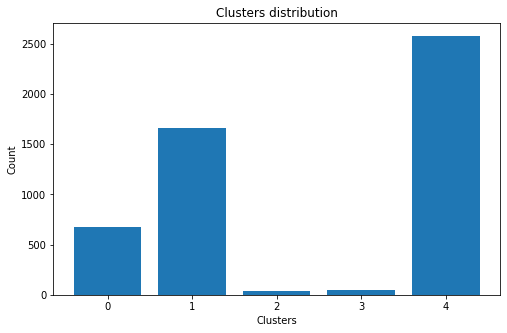

In [97]:
labels_clast_5_test = kmeans_5.predict(df_test_district_scaled)
labels_clast_5_test = pd.Series(labels_clast_5_test, name='clusters_5')

labels_clast_5_test
unique, counts = np.unique(labels_clast_5_test, return_counts=True)
display_clusters_distribution(unique, counts)

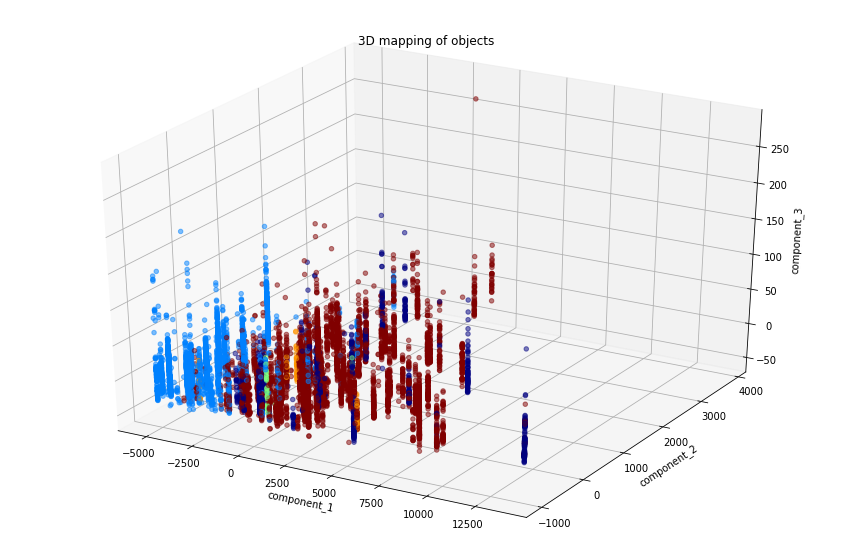

In [98]:
display_components_in_3D_space(components_3d_PCA_train, labels_clast_5_train)

In [99]:
clusters_5_dummies_train = pd.get_dummies(labels_clast_5_train, drop_first=True, prefix='cluster')
clusters_5_dummies_test = pd.get_dummies(labels_clast_5_test, drop_first=True, prefix='cluster')

In [100]:
clusters_5_dummies_test

,cluster_1,cluster_2,cluster_3,cluster_4
0,1,0,0,0
1,1,0,0,0
2,0,0,0,1
3,0,0,1,0
4,1,0,0,0
...,...,...,...,...
4995,0,0,0,1
4996,1,0,0,0
4997,0,0,0,0
4998,1,0,0,0


In [101]:
df_train_district_scaled.columns.tolist()

['Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Shops_1',
 'Ecology_2_A',
 'Ecology_2_B',
 'Ecology_3_A',
 'Ecology_3_B',
 'Shops_2_A',
 'Shops_2_B',
 'Rooms_0',
 'Rooms_1',
 'Rooms_2',
 'Rooms_3',
 'Rooms_4',
 'Rooms_5',
 'Healthcare_2_0',
 'Healthcare_2_1',
 'Halthcare_2_2',
 'Healthcare_2_3',
 'Healthcare_2_4',
 'Healthcare_2_5',
 'Healthcare_2_6',
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,


In [102]:
feature_names = ['Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Shops_1',
 'Ecology_2_A',
 'Ecology_2_B',
 'Ecology_3_A',
 'Ecology_3_B',
 'Shops_2_A',
 'Shops_2_B',
 'Rooms_0',
 'Rooms_1',
 'Rooms_2',
 'Rooms_3',
 'Rooms_4',
 'Rooms_5',
 'Healthcare_2_0',
 'Healthcare_2_1',
 'Halthcare_2_2',
 'Healthcare_2_3',
 'Healthcare_2_4',
 'Healthcare_2_5',
 'Healthcare_2_6']
target_name = ['Price']

In [103]:
components_3d_PCA_train

,component_1,component_2,component_3
0,2626.772717,-668.142609,-14.105155
1,4959.968933,-743.012089,6.188747
2,2409.973288,-759.643184,-18.651984
3,384.048622,90.808781,-7.420700
4,422.895222,1084.904119,-23.978602
...,...,...,...
9991,2610.759427,-638.155248,-12.435611
9992,208.386863,1306.324861,-19.236471
9993,-4722.203393,178.298880,-3.445490
9994,-301.220145,-669.591962,-17.191416


In [104]:
df_train = pd.concat([df_train['Id'], df_train_district[feature_names], clusters_5_dummies_train, df_train[target_name]], axis=1)
df_test = pd.concat([df_test['Id'], df_test_district[feature_names], clusters_5_dummies_test], axis=1)

In [105]:
df_train

,Id,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Shops_1,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B,Rooms_0,Rooms_1,Rooms_2,Rooms_3,Rooms_4,Rooms_5,Healthcare_2_0,Healthcare_2_1,Halthcare_2_2,Healthcare_2_3,Healthcare_2_4,Healthcare_2_5,Healthcare_2_6,cluster_1,cluster_2,cluster_3,cluster_4,Price
0,14038.0,47.981561,29.442751,6.0,7.0,9.0,1969.0,0.089040,33.0,7976.0,5.0,320.0,11.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,184966.930730
1,15053.0,65.683640,40.049543,8.0,7.0,9.0,1978.0,0.000070,46.0,10309.0,1.0,240.0,16.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,300009.450063
2,4765.0,44.947953,29.197612,0.0,8.0,12.0,1968.0,0.049637,34.0,7759.0,0.0,229.0,3.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,220925.908524
3,5809.0,53.352981,33.352981,6.0,8.0,17.0,1977.0,0.437885,23.0,5735.0,3.0,1084.0,5.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,175616.227217
4,10783.0,39.649192,23.776169,7.0,11.0,12.0,1976.0,0.012339,35.0,5776.0,1.0,2078.0,4.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,150226.531644
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,77.0,50.401785,30.476203,5.0,5.0,6.0,1968.0,0.135650,46.0,7960.0,6.0,350.0,11.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,196684.316040
9996,6159.0,41.521546,20.539216,9.0,13.0,13.0,2000.0,0.000000,30.0,5562.0,0.0,2300.0,5.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,189050.289571
9997,5123.0,47.939008,36.939008,1.0,12.0,16.0,2015.0,0.072158,2.0,629.0,1.0,1183.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,159143.805370
9998,5400.0,43.602562,33.840147,8.0,1.0,5.0,1961.0,0.307467,30.0,5048.0,9.0,325.0,5.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,181595.339808


In [106]:
df_train = df_train.dropna()
len(df_train) - df_train.count()

Id                0
Square            0
LifeSquare        0
KitchenSquare     0
Floor             0
HouseFloor        0
HouseYear         0
Ecology_1         0
Social_1          0
Social_2          0
Social_3          0
Healthcare_1      0
Shops_1           0
Ecology_2_A       0
Ecology_2_B       0
Ecology_3_A       0
Ecology_3_B       0
Shops_2_A         0
Shops_2_B         0
Rooms_0           0
Rooms_1           0
Rooms_2           0
Rooms_3           0
Rooms_4           0
Rooms_5           0
Healthcare_2_0    0
Healthcare_2_1    0
Halthcare_2_2     0
Healthcare_2_3    0
Healthcare_2_4    0
Healthcare_2_5    0
Healthcare_2_6    0
cluster_1         0
cluster_2         0
cluster_3         0
cluster_4         0
Price             0
dtype: int64

### Сохранение данных

In [107]:
df_train.to_csv(PREPARED_TRAIN_DATASET_PATH, index=False, encoding='utf-8')
df_test.to_csv(PREPARED_TEST_DATASET_PATH, index=False, encoding='utf-8')

### Анализ целевой переменной

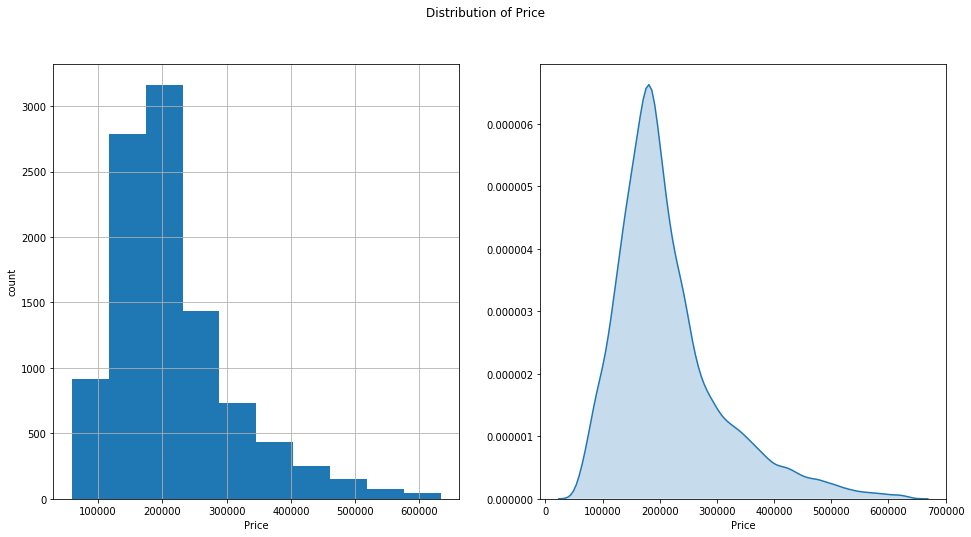

In [108]:
plt.figure(figsize = (16, 8))

plt.subplot(121)
df_train['Price'].hist()
plt.ylabel('count')
plt.xlabel('Price')

plt.subplot(122)
sns.kdeplot(df_train['Price'], shade=True, legend=False)
plt.xlabel('Price')

plt.suptitle('Distribution of Price')
plt.show()

In [109]:
target_mean = round(df_train['Price'].mean(), 2)
target_median = df_train['Price'].median()
target_mode = df_train['Price'].mode()[0]

target_mean, target_median, target_mode

(214155.57, 192290.0392148593, 59174.77802758122)

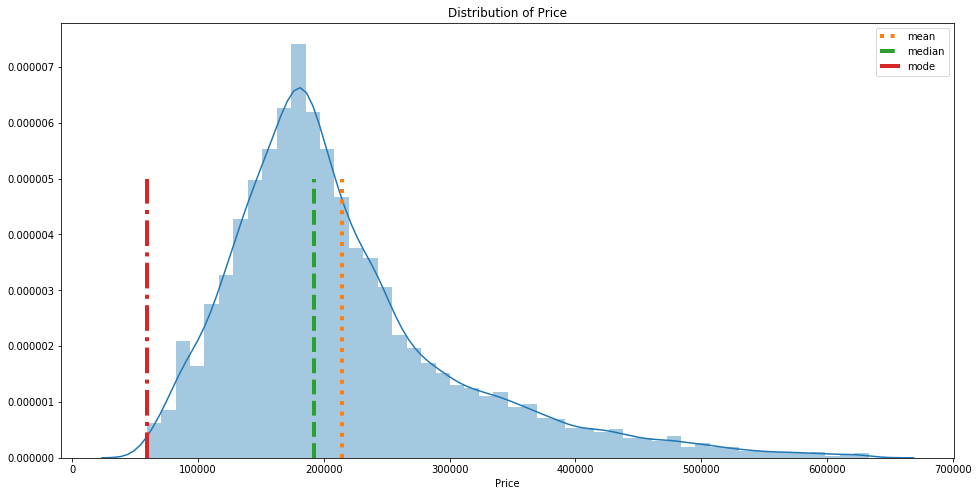

In [110]:
plt.figure(figsize = (16, 8))

sns.distplot(df_train['Price'])

y = np.linspace(0, 0.000005, 100)

plt.plot([target_mean] * 100, y, label='mean', linestyle=':', linewidth=4)
plt.plot([target_median] * 100, y, label='median', linestyle='--', linewidth=4)
plt.plot([target_mode] * 100, y, label='mode', linestyle='-.', linewidth=4)

plt.title('Distribution of Price')
plt.legend()
plt.show()


### Отбор признаков

In [111]:
df_train.columns.tolist()

['Id',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Shops_1',
 'Ecology_2_A',
 'Ecology_2_B',
 'Ecology_3_A',
 'Ecology_3_B',
 'Shops_2_A',
 'Shops_2_B',
 'Rooms_0',
 'Rooms_1',
 'Rooms_2',
 'Rooms_3',
 'Rooms_4',
 'Rooms_5',
 'Healthcare_2_0',
 'Healthcare_2_1',
 'Halthcare_2_2',
 'Healthcare_2_3',
 'Healthcare_2_4',
 'Healthcare_2_5',
 'Healthcare_2_6',
 'cluster_1',
 'cluster_2',
 'cluster_3',
 'cluster_4',
 'Price']

In [112]:
feature_names = [
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Shops_1',
 'Ecology_2_A',
 'Ecology_2_B',
 'Ecology_3_A',
 'Ecology_3_B',
 'Shops_2_A',
 'Shops_2_B',
 'Rooms_0',
 'Rooms_1',
 'Rooms_2',
 'Rooms_3',
 'Rooms_4',
 'Rooms_5',
 'Healthcare_2_0',
 'Healthcare_2_1',
 'Halthcare_2_2',
 'Healthcare_2_3',
 'Healthcare_2_4',
 'Healthcare_2_5',
 'Healthcare_2_6',
 
 'cluster_1',
 'cluster_2',
 'cluster_3',
 'cluster_4'
]
target_name = ['Price']

In [113]:
df_train.head()

,Id,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Shops_1,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B,Rooms_0,Rooms_1,Rooms_2,Rooms_3,Rooms_4,Rooms_5,Healthcare_2_0,Healthcare_2_1,Halthcare_2_2,Healthcare_2_3,Healthcare_2_4,Healthcare_2_5,Healthcare_2_6,cluster_1,cluster_2,cluster_3,cluster_4,Price
0,14038.0,47.981561,29.442751,6.0,7.0,9.0,1969.0,0.089040,33.0,7976.0,5.0,320.0,11.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,184966.930730
1,15053.0,65.683640,40.049543,8.0,7.0,9.0,1978.0,0.000070,46.0,10309.0,1.0,240.0,16.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,300009.450063
2,4765.0,44.947953,29.197612,0.0,8.0,12.0,1968.0,0.049637,34.0,7759.0,0.0,229.0,3.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,220925.908524
3,5809.0,53.352981,33.352981,6.0,8.0,17.0,1977.0,0.437885,23.0,5735.0,3.0,1084.0,5.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,175616.227217
4,10783.0,39.649192,23.776169,7.0,11.0,12.0,1976.0,0.012339,35.0,5776.0,1.0,2078.0,4.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,150226.531644


In [114]:
df_train = df_train[feature_names + target_name]
df_train.describe()

,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Shops_1,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B,Rooms_0,Rooms_1,Rooms_2,Rooms_3,Rooms_4,Rooms_5,Healthcare_2_0,Healthcare_2_1,Halthcare_2_2,Healthcare_2_3,Healthcare_2_4,Healthcare_2_5,Healthcare_2_6,cluster_1,cluster_2,cluster_3,cluster_4,Price
count,9992.000000,9992.000000,9992.000000,9992.000000,9992.000000,9992.000000,9992.000000,9992.000000,9992.000000,9992.000000,9992.000000,9992.000000,9992.000000,9992.000000,9992.000000,9992.000000,9992.000000,9992.000000,9992.000000,9992.000000,9992.000000,9992.000000,9992.000000,9992.000000,9992.000000,9992.000000,9992.000000,9992.000000,9992.000000,9992.000000,9992.000000,9992.000000,9992.000000,9992.000000,9992.000000,9992.000000
mean,56.296301,37.581436,5.706465,7.698459,13.436249,1984.860288,0.118885,24.681245,5351.277922,8.044235,994.065352,4.230084,0.009708,0.990292,0.027422,0.972578,0.082366,0.917634,0.000801,0.370496,0.388211,0.223679,0.015012,0.001801,0.421437,0.218475,0.115592,0.167034,0.028823,0.038731,0.009908,0.340272,0.005805,0.009708,0.508207,214155.569385
std,19.142950,16.451417,3.822009,5.302259,6.093945,18.409908,0.119036,17.524571,4005.099622,23.840616,941.854102,4.806454,0.098053,0.098053,0.163318,0.163318,0.274935,0.274935,0.028286,0.482962,0.487367,0.416730,0.121606,0.042407,0.493814,0.413232,0.319752,0.373025,0.167317,0.192963,0.099049,0.473824,0.075971,0.098053,0.499958,92890.185853
min,20.000000,10.523868,0.000000,0.000000,1.000000,1910.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,41.865867,25.116704,1.000000,4.000000,9.000000,1974.000000,0.017647,6.000000,1564.000000,0.000000,240.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,153835.918927
50%,52.621648,33.792373,6.000000,7.000000,14.000000,1977.000000,0.075424,25.000000,5285.000000,2.000000,705.000000,3.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,192290.039215
75%,65.990475,46.446554,8.000000,11.000000,17.000000,2001.000000,0.195781,36.000000,7227.000000,5.000000,1406.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,249177.966254
max,275.645284,233.949309,42.000000,42.000000,117.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,633233.466570


### Разбиение на train и valid

In [115]:
X = df_train[feature_names]
y = df_train[target_name]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, shuffle = True, random_state=42)

### Random Forest с кросс-валидацией

In [116]:
parameters = [{'n_estimators': [150, 200, 250], 'max_features': (5,9), 'max_depth': np.arange(5,10)}]

In [117]:
rf_model = GridSearchCV(estimator = RandomForestRegressor(random_state=100), param_grid=parameters, scoring='r2', cv=5)
rf_model.fit(X_train,y_train.values.ravel())

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=100,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_job

In [118]:
rf_model.best_params_

{'max_depth': 9, 'max_features': 9, 'n_estimators': 250}

In [119]:
r2_score_train = []
r2_score_valid = []
for val in max_depth_arr:
    rf_model = RandomForestRegressor(n_estimators=250, max_depth=val, max_features= 9, random_state=100)
    rf_model.fit(X_train, y_train.values.ravel())
    y_pred_train = rf_model.predict(X_train)
    y_pred_valid = rf_model.predict(X_valid)
    r2_train = r2(y_train, y_pred_train)
    r2_valid = r2(y_valid, y_pred_valid)
    r2_score_train.append(r2_train)
    r2_score_valid.append(r2_valid)

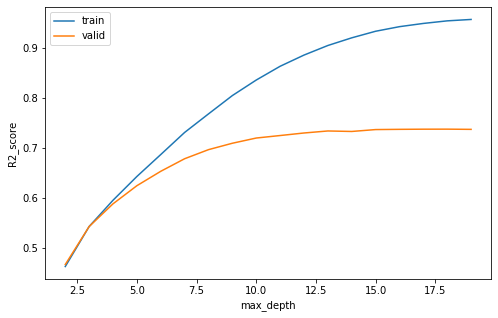

In [120]:
rcParams['figure.figsize'] = 8, 5
plt.plot(max_depth_arr, r2_score_train)
plt.plot(max_depth_arr, r2_score_valid)
plt.xlabel('max_depth')
plt.ylabel('R2_score')
plt.legend(['train', 'valid'])

In [121]:
rf_model = RandomForestRegressor(n_estimators=250, max_depth=17, max_features= 9, random_state=100)

C:\Users\varva\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


R2:	0.948
MAE:	13196.328
MSE:	435688338.566


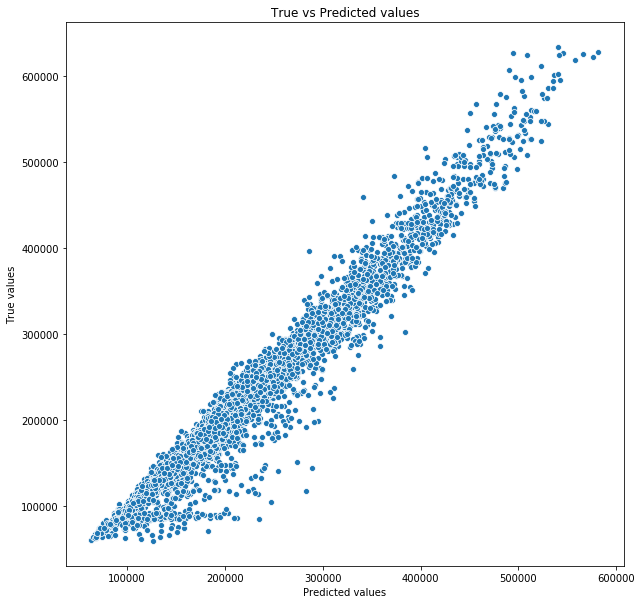

In [122]:
rf_model.fit(X_train, y_train)
y_train_preds = rf_model.predict(X_train)
evaluate_preds(y_train.values.flatten(), y_train_preds.flatten())

R2:	0.737
MAE:	29583.677
MSE:	2387378736.742


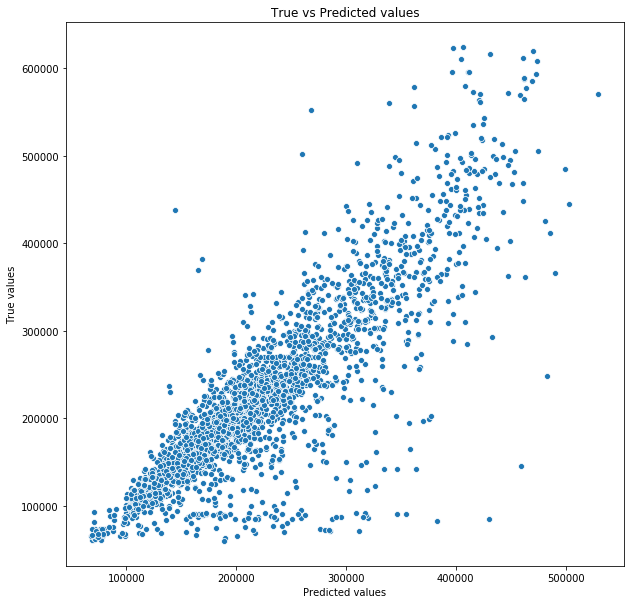

In [123]:
y_valid_preds = rf_model.predict(X_valid)
evaluate_preds(y_valid.values.flatten(), y_valid_preds.flatten())

# Финальный прогноз на тестовых данных

In [124]:
X_train_final = df_train[feature_names]
y_train_final = df_train[target_name]

In [125]:
X_train_final.head()

,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Shops_1,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B,Rooms_0,Rooms_1,Rooms_2,Rooms_3,Rooms_4,Rooms_5,Healthcare_2_0,Healthcare_2_1,Halthcare_2_2,Healthcare_2_3,Healthcare_2_4,Healthcare_2_5,Healthcare_2_6,cluster_1,cluster_2,cluster_3,cluster_4
0,47.981561,29.442751,6.0,7.0,9.0,1969.0,0.089040,33.0,7976.0,5.0,320.0,11.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,65.683640,40.049543,8.0,7.0,9.0,1978.0,0.000070,46.0,10309.0,1.0,240.0,16.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,44.947953,29.197612,0.0,8.0,12.0,1968.0,0.049637,34.0,7759.0,0.0,229.0,3.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,53.352981,33.352981,6.0,8.0,17.0,1977.0,0.437885,23.0,5735.0,3.0,1084.0,5.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,39.649192,23.776169,7.0,11.0,12.0,1976.0,0.012339,35.0,5776.0,1.0,2078.0,4.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [126]:
X_test_final = df_test[feature_names]

In [127]:
X_test_final.head()

,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Shops_1,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B,Rooms_0,Rooms_1,Rooms_2,Rooms_3,Rooms_4,Rooms_5,Healthcare_2_0,Healthcare_2_1,Halthcare_2_2,Healthcare_2_3,Healthcare_2_4,Healthcare_2_5,Healthcare_2_6,cluster_1,cluster_2,cluster_3,cluster_4
0,49.882643,33.432782,6.0,6,14,1972,0.310199,11,2748,1,145.0,0,0,1,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0
1,69.263183,54.263183,1.0,1,6,1977,0.075779,6,1437,3,990.0,2,0,1,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0
2,20.000000,13.597819,6.0,2,5,1909,0.000000,30,7538,87,4702.0,5,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
3,73.046609,51.940842,9.0,22,22,2007,0.101872,23,4583,3,1308.0,3,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0
4,47.527111,43.387569,1.0,17,17,2017,0.072158,2,629,1,1183.0,0,0,1,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0


C:\Users\varva\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


R2:	0.944
MAE:	14019.969
MSE:	485661739.738


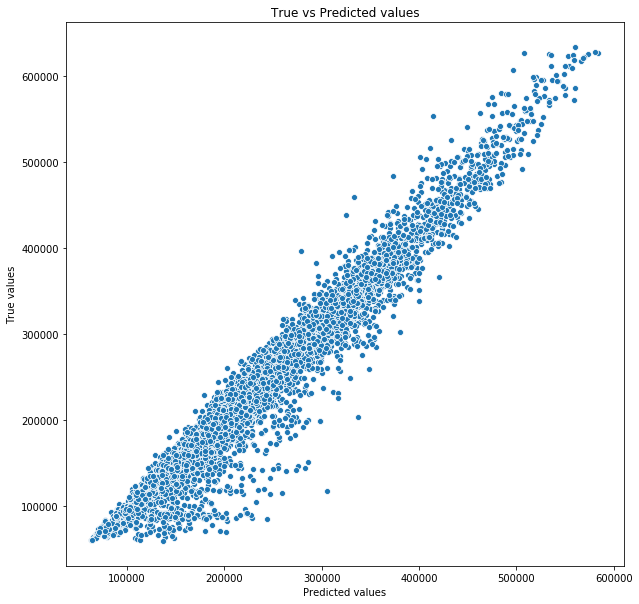

In [128]:
rf_model.fit(X_train_final, y_train_final)
y_train_final_preds = rf_model.predict(X_train_final)
evaluate_preds(y_train_final.values.flatten(), y_train_final_preds.flatten())

In [129]:
y_test_final_preds = rf_model.predict(X_test_final)

In [130]:
y_test_final_preds

array([162685.37407112, 217835.35261247, 193389.2508608 , ...,
       334659.5988686 , 197852.71656484, 172219.26861013])

In [131]:
df_test

,Id,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Shops_1,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B,Rooms_0,Rooms_1,Rooms_2,Rooms_3,Rooms_4,Rooms_5,Healthcare_2_0,Healthcare_2_1,Halthcare_2_2,Healthcare_2_3,Healthcare_2_4,Healthcare_2_5,Healthcare_2_6,cluster_1,cluster_2,cluster_3,cluster_4
0,725,49.882643,33.432782,6.0,6,14,1972,0.310199,11,2748,1,145.0,0,0,1,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0
1,15856,69.263183,54.263183,1.0,1,6,1977,0.075779,6,1437,3,990.0,2,0,1,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0
2,5480,20.000000,13.597819,6.0,2,5,1909,0.000000,30,7538,87,4702.0,5,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
3,15664,73.046609,51.940842,9.0,22,22,2007,0.101872,23,4583,3,1308.0,3,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0
4,14275,47.527111,43.387569,1.0,17,17,2017,0.072158,2,629,1,1183.0,0,0,1,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,8180,67.133911,50.809797,6.0,5,9,1973,0.000170,36,5992,0,1130.0,1,0,1,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1
4996,4695,40.198472,21.807061,10.0,12,17,2017,0.007122,1,264,0,240.0,1,0,1,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
4997,5783,77.842178,48.282625,9.0,22,23,1989,0.090799,74,19083,2,176.0,15,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
4998,4780,81.305222,67.305222,0.0,0,4,1977,0.072158,2,629,1,2300.0,0,0,1,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0


In [132]:
y_test_final_preds = pd.DataFrame(data = y_test_final_preds, columns = ['Price'])

In [133]:
df_test_final =pd.concat([df_test['Id'],y_test_final_preds], axis = 1)

In [134]:
df_test_final

,Id,Price
0,725,162685.374071
1,15856,217835.352612
2,5480,193389.250861
3,15664,356800.363132
4,14275,139649.453475
...,...,...
4995,8180,240439.043308
4996,4695,128969.532224
4997,5783,334659.598869
4998,4780,197852.716565


In [139]:
df_test_final.to_csv(PREPARED_TEST_DATASET_PATH, index=False, encoding='utf-8')